In [1]:
import os
import _pickle as cPickle
#import cPickle as pickle
import numpy as np
import xml.etree.ElementTree as ET
import random
from utils_nb import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 10, U_items=10, limit = 500, alphabet="default"):
        self.data_dir = "data"
        self.alphabet = alphabet
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor # divide data by this factor
        self.limit = limit # removes large noisy gaps in the data
        self.U_items = U_items

        data_file = os.path.join(self.data_dir, "strokes_training_data.cpkl")
        stroke_dir = self.data_dir+"\lineStrokes"
        ascii_dir = self.data_dir+"\ascii"
        #print(stroke_dir)

        if not (os.path.exists(data_file)) :
            print("creating training data cpkl file from raw source")
            self.preprocess(stroke_dir, ascii_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, stroke_dir, ascii_dir, data_file):
        # create data file from raw xml files from iam handwriting source.
        print("Parsing dataset...")
        
        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = stroke_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
            #print('Found directory: %s' % dirName)
            for fname in fileList:
                #print('\t%s' % fname)
                filelist.append(dirName+"/"+fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
                result.append(points)
            return result
        
        # function to read each individual xml file
        def getAscii(filename, line_number):
            with open(filename, "r") as f:
                s = f.read()
            s = s[s.find("CSR"):]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""
                
        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):
            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j])-1)): # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        asciis = []
        for i in range(len(filelist)):
            #print(filelist[i])
            if (filelist[i][-3:] == 'xml'):
                stroke_file = filelist[i]
                #print('processing '+stroke_file)
                stroke = convert_stroke_to_array(getStrokes(stroke_file))
                
                ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
                line_number = stroke_file[-6:-4]
                line_number = int(line_number) - 1
                ascii = getAscii(ascii_file, line_number)
                if len(ascii) > 10:
                    print("Larger value: " + ascii)
                    strokes.append(stroke)
                    asciis.append(ascii)
                else:
                    print("======>>>> Line length was too short. Line was: " + ascii)
                
        assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
        f = open(data_file,"wb")
        pickle.dump([strokes,asciis], f, protocol=2)
        f.close()
        print("Finished parsing dataset. Saved {} lines".format(len(strokes)))


    def load_preprocessed(self, data_file):
        f = open(data_file,"rb")
        [self.raw_stroke_data, self.raw_ascii_data] = pickle.load(f)
        f.close()

        # goes thru the list, and only keeps the text entries that have more than tsteps points
        self.stroke_data = []
        self.ascii_data = []
        counter = 0

        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if len(data) > (self.tsteps+2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data,dtype=np.float32)
                data[:,0:2] /= self.scale_factor
                
                self.stroke_data.append(data)
                self.ascii_data.append(self.raw_ascii_data[i])

        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(len(self.stroke_data) / self.batch_size)
        print("Loaded dataset:")
        print("   -> {} individual data points".format(len(self.stroke_data)))
        print("   -> {} batches".format(self.num_batches))

    def next_batch(self):
        # returns a randomised, tsteps sized portion of the training data
        x_batch = []
        y_batch = []
        ascii_list = []
        for i in range(self.batch_size):
            data = self.stroke_data[self.idx_perm[self.pointer]]
            x_batch.append(np.copy(data[:self.tsteps]))
            y_batch.append(np.copy(data[1:self.tsteps+1]))
            ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
            self.tick_batch_pointer()
        one_hots = [self.one_hot(s) for s in ascii_list]
        return x_batch, y_batch, ascii_list, one_hots
    
    def one_hot(self, s):
        #index position 0 means "unknown"
        if self.alphabet is "default":
            alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
        seq = [alphabet.find(char) + 1 for char in s]
        if len(seq) >= self.U_items:
            seq = seq[:self.U_items]
        else:
            seq = seq + [0]*(self.U_items - len(seq))
        one_hot = np.zeros((self.U_items,len(alphabet)+1))
        one_hot[np.arange(self.U_items),seq] = 1
        return one_hot

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.stroke_data)):
            self.reset_batch_pointer()
    def reset_batch_pointer(self):
        self.idx_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
        print("pointer reset")

In [3]:
batch_size = 5
tsteps = 700
data_scale = 50
U_items = int(tsteps/20)
data_loader = DataLoader(batch_size=batch_size, tsteps=tsteps, \
                         scale_factor=data_scale, U_items=U_items, alphabet="default")

creating training data cpkl file from raw source
Parsing dataset...
Larger value: A MOVE to stop Mr . Gaitskell
Larger value: from nomnating any more Labour
Larger value: life Peers is to be made at a
Larger value: meeting of Labour M Ps tomorrow
Larger value: Mr . Michael Foot has put down a
Larger value: resolution on the subject
Larger value: By Trevor Williams. A move to 
Larger value: stop Mr. Gaitskell from nominating 
Larger value: any more Labour life Peers is to 
Larger value: be made at a meeting of Labour 
Larger value: M Ps tomorrow. Mr. Michael Foot has 
Larger value: put down a resolution on the subject 
Larger value: and he is to be backed by Mr Will 
Larger value: Griffiths, MP for Manchester Exchange. 
Larger value: By Trevor Williams. A move 
Larger value: to stop Mr. Gaitskell from 
Larger value: nominating any more Labour 
Larger value: life Peers is to be made at a 
Larger value: meeting of Labour M Ps 
Larger value: tomorrow. Mr. Michael Foot has 
Larger value: pu

Larger value: Horrified. That ' s a Tory 
Larger value: doctor ' s reaction to the new 
Larger value: health charges, says George 
Larger value: Brown. " Probe the drugs 
Larger value: profits and don ' t take it 
Larger value: out of mothers and children " . 
Larger value: By Hugh Pilcher. 
Larger value: The result of the vote was not in doubt. Mr.
Larger value: Brown declared that the policy under censure
Larger value: was monstrous. It had offended many people far
Larger value: beyond the ranks of Labour supporters. The
======>>>> Line length was too short. Line was: letter.
Larger value: "After a lifetime of helping
Larger value: others and healing the
Larger value: sick, my considered opinion
Larger value: is that anybody supporting
Larger value: the increased charges is
Larger value: a wicked, old -. Mr. Brown
Larger value: went on :" We are dealing
Larger value: with a noble edifice
Larger value: which needs an
Larger value: imaginative architect.
Larger value: Mr . Brown , pass

Larger value: say that I don't accept his good faith.
Larger value: He said Mr. Kaunda must know that his
Larger value: statements had stimulated violence, but he
Larger value: had done nothing to stop it.
Larger value: Its terms have set 
Larger value: the Prime Minister 
Larger value: an exacting problem. 
Larger value: Mr. Sandys has warned of the risk 
Larger value: of a strong reaction from Sir Roy 
Larger value: Welensky to any suggestion that 
Larger value: there may be fresh concessione to the 
Larger value: African Nationalists. 
Larger value: Then their views will be
Larger value: transmitted back. Russell
Larger value: jailed but ban-the-bomb
Larger value: fight goes on. Rab cracks
Larger value: down. By daily mail reporter.
Larger value: Mr. Butler, The home Secretary,
Larger value: has decided to meet head-on
Larger value: the biggest challenge to Govern-
Larger value: ment authority yet presented
Larger value: by the ban-the-bomb
Larger value: demonstrators.
Larger value:

Larger value: that justify the protests and 
Larger value: these should carry weight 
Larger value: with the U.S. Government, 
Larger value: Earl Russell suggested. 
Larger value: The third reason is that the
Larger value: supreme interest for the
Larger value: whole World - East and West
Larger value: and uncommitted nations -
Larger value: is the prevention of nuclear
Larger value: war. "One fore" aim for Services.
Larger value: The three Services would be
Larger value: "integrated" to a greater extent
Larger value: than ever before. There would
Larger value: be complete co-operation at all
Larger value: levels in training and operations.
Larger value: This would apply also in the
Larger value: command structure and
Larger value: Central administrative organisation.
Larger value: The Minister regards 
Larger value: the recent trend of re- 
Larger value: cruiting figures as encouraging. 
Larger value: He is confident the aim can be 
Larger value: achieved. No question of dispute. If 


Larger value: He dismissed the idea
Larger value: that Britain would be
Larger value: swamped by cheap Labour.
Larger value: Refugess are pouring out of
Larger value: East Germany into West Berlin faster
Larger value: than ever. This figure has been sur-
Larger value: passed only on the eve of the East
Larger value: German disturbances on July
======>>>> Line length was too short. Line was: 17, 1953.
Larger value: Capsized. He should have an easy task
Larger value: in the last event. Retour De Flamme for the
Larger value: "replay". By Peter O'Sullevan. Retour De
Larger value: Flamme was frequently backed to beat
Larger value: Tokoroa over hurdles, but in six encounters
Larger value: he never succeeded.
Larger value: The blot? He could prove a blot on the
Larger value: handicap - as connections hope. Merganser
Larger value: Also seems well treated, and Johnny Lehane
Larger value: is confident of a bold bid by Miss Popsi
======>>>> Line length was too short. Line was: Wopsi.
Larger value

Larger value: poor girl, she committed
Larger value: a minor social sin.
Larger value: The play at the Vaudewille
Larger value: Theatre? Appropriately "the
Larger value: bride comes back. Old boys.
Larger value: One of London's odder reunions
Larger value: took place last night. He had
Larger value: dinner with group Captain
Larger value: Douglas Bader at his London
Larger value: mews house.
Larger value: When he escaped I was hauled over
Larger value: the coals and almost wished I had
Larger value: escaped with him. ' I can't understand Lord
Larger value: Harewood's interest in music after Reid's
Larger value: performance. The Earl of Harewood was
Larger value: another of his prisoners.
Larger value: And since the duke
Larger value: is the landlord of
Larger value: the building (rent 1
Larger value: s a year) he was the
Larger value: obvious choice as guest of
Larger value: honour. I am a bit ol, "he
Larger value: explained almost apologetically,"
Larger value: for that sort of thing.

Larger value: made. India has responded handsomely by
Larger value: providing 3,000 men, who must take about
Larger value: a fortnight to arrive.
Larger value: Yesterday the ships turned
Larger value: away again, satisfied that they
Larger value: were not required. But back, Mr.
Larger value: Hammarskjold is determined, they
Larger value: must go. The best news for the
Larger value: Congo would be agreement between
Larger value: its rival political be lee.
Larger value: Small nations would not
Larger value: remain free for long in this
Larger value: World if the UN was not
Larger value: their bulwark. The smile on
Larger value: the face of Verwoerd. He has
Larger value: made a strong impression. But
Larger value: not, perhaps, quite the impression
Larger value: that he intended.
Larger value: It was Dr. Verwoerd who
Larger value: led a protest against admitting any
Larger value: of them because they would
Larger value: "defile" the National white stock.
Larger value: It is impossible t

Larger value: Mr. Luthuli cannot speak freely to
Larger value: us. But he must draw
Larger value: encouragement from the re-
Larger value: ception that he will receive here
Larger value: and elsewhere on his journey. "Who
Larger value: will deny", he has said sadly, "that
Larger value: thirty years of my life have been spent
Larger value: in knocking in vain at a closed and
Larger value: barred door?
Larger value: To this there will be some
Larger value: Opposition. This fact may
Larger value: give the Government an extra
Larger value: excuse for counselling patience
Larger value: until the next report from
Larger value: the Molony Committee. Comprehensive
Larger value: legislation is obviously preferable.
Larger value: It is true that Sir Graham
Larger value: said there is at the moment
Larger value: "an awful mess up" in the measure-
Larger value: ment of temperatures. This, how-
Larger value: ever, seems a matter of the
Larger value: convenience of specialists.
Larger value: Can it 

Larger value: methods that have # led
Larger value: to restrictive practices .
Larger value: Now a new threat to
Larger value: those who toil and spin
Larger value: has been developed by a
Larger value: firm specialising in
Larger value: electronics
Larger value: They really believed that
Larger value: the Treaty of Versailles was
Larger value: an iniquitous injustice . When
Larger value: they burst into Czechoslovakia ,
Larger value: Poland , Holland , Belgium
Larger value: and France they really
Larger value: believed Hitler when he
Larger value: screamed at them that they
Larger value: were being "encircled ." They
Larger value: In no other conquered country , not even
Larger value: Poland , had the germans begun with such a
Larger value: drastic step . There is no doubt that the
Larger value: compatriots of Eichmann would have been
Larger value: as good as their evil word . THE
Larger value: Inland Revenue people have a
Larger value: Their demands are
Larger value: invariably couch

Larger value: Obstruction. Hopes rose as we saw
Larger value: a perspective of sharp struggle
Larger value: bad based on consistent lines of
Larger value: difference with the Tories. They
Larger value: obstructed every effort to fight for
Larger value: the Scarborough decisions, while
Larger value: scratching around frantically to
Larger value: overturn them next time.
Larger value: In unions where the
Larger value: Central issues were
Larger value: confused, clear policy detail -
Larger value: as on base - # were decisively
Larger value: carried. Peace policy. All recent
Larger value: events show how correct the
Larger value: Scarborough decisions were.
Larger value: The statement of Padley and
Larger value: Crossman is no different in principle
Larger value: to the new Defence statement. They
Larger value: accept American nuclear bases, and
Larger value: also the use of nuclear weapons.
Larger value: and nuclear strategy until some
Larger value: future date.
Larger value: There is on

Larger value: 112 Wythenshawe Road,
Larger value: Manchester 23. BEA Services
Larger value: in Scotland. I suspect that
Larger value: the waste-paper basket is
Larger value: Lord Douglas's filing Cabinet
Larger value: Vast gleaming counters await
Larger value: the prospective continental
Larger value: traveller. The internal passen-
Larger value: gers need a native guide and
Larger value: the gods on their side to find
Larger value: the booking counting allotted
======>>>> Line length was too short. Line was: to them.
Larger value: But farther North? One has to
Larger value: book at least six weeks in advance.
Larger value: Put on extra flights? There 's another
Larger value: idea for the waste-paper basket.
Larger value: Yours faithfully, Mark Murray
Larger value: Threipland.
Larger value: Letters to the
Larger value: editor. The bill for
Larger value: drugs. On November 9
Larger value: he states: "Since price re-
Larger value: straint became operative
Larger value: the industry has w

Larger value: island, prays, and in a second miracle 
Larger value: the night club is replaced in its 
Larger value: original setting. 
Larger value: Wicki Suddenly returns to the
Larger value: city for a final epilogue. Wicki has
Larger value: succeeded in his second film in recording
Larger value: his personal apocalypse of the last days of
Larger value: a sick society.
Larger value: His method of painting with the
Larger value: camera has never been more exciting,
Larger value: exchanging the rocks of Sicily for the
Larger value: skyscrapers of Milan. But his society is
Larger value: the same, now even clearer, but
Larger value: touched with a melancholy compassion
Larger value: which is a strong sign of the
Larger value: maturity of his ultimate artistic vision.
Larger value: It has a great look of
Larger value: speed and technical fun
Larger value: about it , of enormous
Larger value: cinematic enjoyment , and
Larger value: above all of cinematic
Larger value: sense . Much of it h

Larger value: Chinese jugglers. 
Larger value: Perhaps it was accidental -
Larger value: I hope not. If ever a bag
Larger value: of humour needed a
Larger value: thorough shaking up the
Larger value: Whitehall farce is it when
Larger value: it comes to television.
Larger value: It 's an old pianna pin-up.
Larger value: Twang a guitar slightly off key.
Larger value: Everybody 's fed up with the right
Larger value: away - so the best-seller charts
Larger value: say. Play an old pianna instead
Larger value: of a new one. You got to get it
Larger value: into your head, son ... people don't
Larger value: like things as they should be - not on
Larger value: record, anyway.
Larger value: Now along comes his solo disc, 
Larger value: featuring two of his own 
Larger value: compositions, " deerstalker " and 
Larger value: " almost grown up. Verdict: 
Larger value: Mr. Lisbon has it taped. And 
Larger value: tacked. And he says: 
Larger value: I find it cute. New boy on the
Larger value: vocal f

Larger value: able to express this
Larger value: better by painting duche-
Larger value: sses or cats or velvet-
Larger value: curtained rooms. In painting
Larger value: He paints the presence of
Larger value: their beautiful vitality, the
Larger value: promise of their decay, the
Larger value: process of transition between
Larger value: them. The artist he resembles
Larger value: most closely in spirit is, I think,
======>>>> Line length was too short. Line was: Watteau.
Larger value: Rodin's Ghost will not be laid. Ralph
Larger value: Brown began as a social realist sculptor infusing
Larger value: tenderness into a gawky mother fondling
Larger value: a child, an infant bowling a hoop. But
Larger value: recently his sculptural conceptions, carried
Larger value: out in ciment fondu for bronze, have
Larger value: become more complex.
Larger value: Thus his forms have become
Larger value: bunched, with knobbly casing
Larger value: and clefts hard to read
Larger value: anatomically, and w

Larger value: the Book we realise that
Larger value: the puzzles and hypotheses
Larger value: which he presents are
Larger value: honest expressions of his own
Larger value: uncertainty.
Larger value: Charming fantasy told with perfect light
Larger value: touch. Delightful surprise ending. The
Larger value: silent speaker by Noel Streatfeild,
Larger value: Collins, 16 s. Neatly-constructed whydunit.
Larger value: Skilful maintenance of suspense right
Larger value: up to not-too-unlikely solution.
Larger value: Grim exploration situation in small
Larger value: South African country town. The
Larger value: World of music. A drastic way with
Larger value: Verdi. By Desmond Shawe-Taylor.
Larger value: The score of "Falstaff" sems to have
Larger value: ripened against a warm orchard wall.
Larger value: His "Falstaff," though likely
Larger value: to prove a hit, is again contro-
Larger value: versial. Visually, it is inventive
Larger value: and often lovely. The worst comes
Larger value: nea

Larger value: The word for toil is
Larger value: also used of sorrow and
Larger value: vexation. This is the problem
Larger value: of communication in the
Larger value: modern industrial World. 3.
Larger value: Under the sun. It means
Larger value: simply "alive".
Larger value: The thought fits Qoheleth's position
Larger value: precisely. The finishing line is
Larger value: continually found to be but the
Larger value: prelude to the starting post - the
Larger value: sun gets nowhere! 6. The wind blows ...
Larger value: the wind returns.
Larger value: The references is to "the
Larger value: underworld, which was thought
Larger value: to be the source both of fresh-
Larger value: water springs and of the salt-
Larger value: water oceans." 9. The eye is
Larger value: not satisfied ... nor the ear
======>>>> Line length was too short. Line was: filled.
Larger value: The act means more than the
Larger value: recalling of past events. The very
Larger value: personality of a man continues in

Larger value: Living the life of
Larger value: the Torah (" dipping-in")
Larger value: makes us meek: "But the
Larger value: meek shall inherit the earth;
Larger value: and shall delight themselves
Larger value: in the abundance of peace"
Larger value: (psalm 37, 11).
Larger value: (This is the pardus .) Matzo
Larger value: represents the literal meaning of
Larger value: Pesach which is called: the feast of
Larger value: Matzos. The bitter-herbs represent
Larger value: the spiritual principle and this
Larger value: gives us "a wink" (Remez) how to
Larger value: live and accept all the bitterness
Larger value: that is hurled against us.
Larger value: There are four ways of redemption:
Larger value: (1). I will bring you out from under the
Larger value: burdens of Egypt. (2). I will rid you of their
======>>>> Line length was too short. Line was: bondage.
Larger value: How was it that Israel was brought
Larger value: out from under the burdens of Egypt?
Larger value: (Gen Rashi 19, 3 .) 

Larger value: than their successors.
Larger value: (A). Makes for a decrease
Larger value: in tiredness. We have a
Larger value: saying "My head will never
Larger value: save my feet". Some of
Larger value: it is inevitable, and we do
Larger value: not want to become too
Larger value: pernickety.
Larger value: I am more than conscious of this.
Larger value: How anybody can go through the same
Larger value: routine day in and day out for forty years
Larger value: I find difficult to understand. But I am
Larger value: not arguing for this.
Larger value: (B). Concentrate on one thing
Larger value: at a time. A list or a plan
Larger value: enables us to put all our energies
Larger value: into the particular matter on
Larger value: hand. 2. We turn now to the
Larger value: consideration of an Aggadic passage;
Larger value: the final portion of tractate Makkoth.
Larger value: To this Rabh Joseph raises
Larger value: an objection and Abaye
Larger value: replies by referring his master
Larger 

Larger value: children. Kant And the utilitarians.
Larger value: There are many ways of being hard
Larger value: to understand. One is due to style.
Larger value: Two famous examples present
Larger value: themselves in the critique of
Larger value: pure reason, where he is analysing
Larger value: the fact of knowledge. First of all
Larger value: the case of the senses and
Larger value: the understanding. They seem
Larger value: to have no Common root.
Larger value: We must keep this dualism in
Larger value: mind when we come to consider
Larger value: what Kant says about the relation
Larger value: of goodness and happiness.
Larger value: In the first he had shown
Larger value: himself a revolutionary. "The
Larger value: inhabitants of Koenigsburg set their
Larger value: watches by him when they saw this mild,
Larger value: inoffensive man take his regular walk.
Larger value: He must be left with
Larger value: something to live by.
Larger value: As Kant says with a regal
Larger value: g

Larger value: small hem, with fold
Larger value: lying on line of
Larger value: basting stitches. Work
Larger value: a row of dc all
Larger value: round this hem, with
Larger value: 3 dc at each corner.
Larger value: Obtainable in the following shades: LIST.
Larger value: How to turn your work. Then the
Larger value: work is turned so that the reverse
Larger value: side is facing the worker. The number
Larger value: of turning chains depends upon the
Larger value: stitch with which you intend to
Larger value: begin the next row.
Larger value: During the sixteenth
Larger value: century a considerable
Larger value: amount of crochet was produced
Larger value: in th convents of Europe .
Larger value: Without doubt it was the
Larger value: nuns who carried the craft
Larger value: to Ireland . There it was
Larger value: developed into quite an
Larger value: elaborate and distinctive
Larger value: These are the correct
Larger value: numbers to use with Mercer-
Larger value: Crochet: TABLE Pr

Larger value: its power lead. Having bought your drill, how do
Larger value: you set about using it? And which of those
Larger value: alluring attachments
Larger value: So, for a start, we
Larger value: can ignore those cheap
Larger value: (and usually Foreign) sets of
Larger value: twist drills on the chain-
Larger value: store tool counters.
Larger value: A good high-speed drill will
Larger value: have the letters HS and
Larger value: the diameter stamped
Larger value: on the shank.
Larger value: That acts as a guide for the drill 
Larger value: point and stops it wandering from 
Larger value: the required position. That ' s where a 
Larger value: bench drilling assembly scores heavyly, 
Larger value: a simple pillar fixture which converts 
Larger value: the power tool into a bench drill. 
Larger value: But whether the power drill
Larger value: is hand-held or used in a
Larger value: bench assembly, let your
Larger value: eyes and ears act as
Larger value: trouble detectors. Watch
La

Larger value: belief in the possibilities of 
Larger value: decorative plastic laminates 
Larger value: in furniture design. We shall 
======>>>> Line length was too short. Line was: see. 
Larger value: Designed for use on either
Larger value: gas or electric stoves, these
Larger value: dishes can be transferred
Larger value: straight from the oven to
Larger value: the table. This is an excellent
Larger value: hardware store where you can
Larger value: buy anything from the most mun-
Larger value: dane of kitchen gadgets to a
Larger value: luxury bathroom fitting.
Larger value: The price is +8 5 s for the chair,
Larger value: and the cushion is extra. If you
Larger value: have any furnishing problems, some
Larger value: at least of the answers will be
Larger value: found at this furnishing store
Larger value: which stocks much top bracket
Larger value: furniture, fabrics and carpets.
Larger value: This crystal is also produced in 
Larger value: Czechoslovakia and comes in various 
Larg

======>>>> Line length was too short. Line was: 1: 100.
Larger value: A British zoologist and
Larger value: entomologist suggested that I try
Larger value: Spanish mantis the season. The first
Larger value: batch of around 50 mantis hatched
Larger value: from this egg-case on June 20.
Larger value: Meanwhile Mr. Moncrieff had sent me
Larger value: an egg-case of the Chinese mantis.
Larger value: A choice of pots. By John
Larger value: T Warren, N.D.H. Despite the
Larger value: steady influx of substitutes
Larger value: since the end of the war.
Larger value: clay pots are still in
Larger value: greatest demand. The storage
Larger value: problem puts clay pots at
Larger value: a definite disadvantage.
Larger value: In their proper setting they are not
Larger value: unattractive and, in spite of their short
Larger value: comings, most gardeners have a nostalgic
Larger value: affection for them. Present-day pots
Larger value: are better finished, do not get dirty
Larger value: so readily 

Larger value: Thus reading for understanding means
Larger value: taking items of knowledge to pieces
Larger value: as we read them and seeing how the
Larger value: pieses are connected. It does not at
Larger value: all correspond to the needs of the
Larger value: reader's mind.
Larger value: They would be loose-leave
Larger value: books. Of course there are
Larger value: many practical objections to
Larger value: such a method of printing
Larger value: but we must ask how the
Larger value: reader overcome the handicaps
Larger value: which the present design of
Larger value: books imposes on him?
Larger value: These are: (1) the philosopher's
Larger value: approach (2) the psychologist's
Larger value: approach (3) the teacher's ap-
Larger value: proach He must be his own
Larger value: philosopher, his own psychologist
Larger value: and his own teacher.
Larger value: He must become a critic
Larger value: of his own methods and
Larger value: an experimenter in the
Larger value: discovery 

Larger value: is one who talks to you
Larger value: about yourself. Incidentally,
Larger value: it 's easy to forget a face.
Larger value: He has the knack of
Larger value: putting things in an
Larger value: interesting way. But more than
Larger value: that, he stimulates you to
Larger value: contribute to the conversation too.
Larger value: And he can set a whole group
======>>>> Line length was too short. Line was: talking.
Larger value: You think the man opposite would like
Larger value: to chat. And so would you. All right!
Larger value: Seize your opportunity when he looks
Larger value: up from his book. What will you say?
Larger value: The usual opening, and you can't better
Larger value: it, is to remark on the weather.
Larger value: So - see the next page! 
Larger value: Yes , they are waiting for you .
Larger value: But there is no need to be
Larger value: frightened . The audience will
Larger value: eat out of your hand -
Larger value: if they like what you offer
Larger value

Larger value: day . During that time a description
Larger value: of the girl was circulated ,
Larger value: and a Mr Robert Money
Larger value: came forward to
Larger value: She had been struck several
Larger value: times with a blunt instrument,
Larger value: and her head was smashed in.
Larger value: There were signs of a violent
Larger value: struggle, blood on the cushions
Larger value: and floor, and the remains of
Larger value: her broken umbrella.
Larger value: Her sister saw her to the station,
Larger value: helping her with some of her packages. This sister
Larger value: was able to establish that she had carried
Larger value: a green purse and had bought a railway
======>>>> Line length was too short. Line was: ticket.
Larger value: At a spot on the embankment
Larger value: between Putney and Wand-
Larger value: worth they found a blood-
Larger value: stained pestle such as
Larger value: chemists use, with some hairs
Larger value: sticking to it. The murder
Larger value: weap

Larger value: AFTER MENTIONING THAT HE
Larger value: HAD DINED WITH LONGFELLOW
Larger value: TOLD THE SAGE A VERY FUNNY
Larger value: STORY WHICH MADE CARLYLE
Larger value: ABSOLUTLY LAUGH; BUT ALL
======>>>> Line length was too short. Line was: THE
Larger value: And, if certain dishes and modes
Larger value: of food have persisted down the
Larger value: ages, the motive that preserved them
Larger value: has always been the same. Apart from
Larger value: the need for nourishment,
Larger value: The fleshpots of Egypt for which
Larger value: Israel sighed. Anyhow, Homer does seem to
Larger value: have known any way of cooking meat
Larger value: except by roasting and boiling. When
Larger value: Achilles gave a Royal feast the principal dish
Larger value: was a grill, which he cooked himself,
Larger value: and he knew how to do it, too: -
Larger value: Having exhausted their invention in the
Larger value: preparation of stimulants for the palate, they broke
Larger value: fresh ground and 

Larger value: Labour supporters on
Larger value: these items were 22 ,
Larger value: 30 and 7 rispectively .)
Larger value: A common view. If fairly
Larger value: Common view was that.
Larger value: Three people in every street changing over could
Larger value: change the Gouvernment. It is on this uncertain
Larger value: group that the choice of Government rests.
Larger value: It 's a grave thought. This Book is worth
======>>>> Line length was too short. Line was: reading.
Larger value: By Frank Horrabin. France -
Larger value: established a protectorate over
Larger value: Tunisia in 1881, three years after
Larger value: the congress of Berlin, at which
Larger value: she had agreed to the British
Larger value: seizure of Cyprus. Five years ago
Larger value: (in 1956) Tunisia became
Larger value: independent - thus anticipating
Larger value: the freeing of Cyprus by a
Larger value: year or two.
Larger value: History on film strip.
Larger value: Besides, if one looks at the
Larger valu

======>>>> Line length was too short. Line was: his
Larger value: But what a change from
Larger value: the dear little old church at
Larger value: Tatsfield to the great modern
Larger value: church of St . Mark ' s at
Larger value: Purley . One felt at Tatsfield
Larger value: that , small as the church was ,
Larger value: it had its own atmosphere , and
Larger value: for centuries had been a House
Larger value: of Prayer . I could not but feel
======>>>> Line length was too short. Line was: the
Larger value: We also had a little
Larger value: Mission Hall leading off the
Larger value: Brighton Road , in a street full
Larger value: of small houses . This was
Larger value: called Ellen Avenue when
Larger value: I first went there , but was
Larger value: soon changed into the better-
Larger value: sounding name of Lansdowne
Larger value: Road . There #
Larger value: The Church Army Captain had done very good work
Larger value: in the Lansdowne Road district, but I needed more help
Larger 

Larger value: his yacht from England
Larger value: The beauty of the place
Larger value: quite exceeded his
Larger value: expectations . 'I am enchanted'
Larger value: , he told Arthur Paget
Larger value: 'Probably the Element 
Larger value: the water] has
Larger value: In mid-April Anglesey
Larger value: moved his family and
Larger value: entourage from Rome
Larger value: to Naples, there to await the
Larger value: arrival of his yacht from England.
Larger value: The beauty of the place quite
Larger value: exceeded his expectations.
Larger value: ,,I am enchanted", he told Arthur
======>>>> Line length was too short. Line was: Paget.
Larger value: "The Pearl", he wrote, "is arrived,
Larger value: which is a great resource. Vesuvius
Larger value: seems to be tired; he is going out
Larger value: fast ... What a gay, lively
Larger value: people, and what a busy town.
Larger value: But he has not one word
Larger value: of English. "What a
Larger value: frightful event!" he wrote.
Larger v

Larger value: to be told that it is coincidence,
Larger value: self-persuasion, a triumph of
Larger value: the human will. But what
Larger value: happened to me during that
Larger value: long illness must be told,
Larger value: plainly and simply.
Larger value: I had just gone through a bad
Larger value: patch of selfishness and disbelief.
Larger value: And I was still a stout protestant,
Larger value: with no great faith in the
Larger value: mystery of the Eucharist. I had
Larger value: tried to provoke him about the
Larger value: Anglo-Catholic church in the
Larger value: town where we were stationed.
Larger value: But none of them convinced me. Yet it was 
Larger value: still bad enough. The army was now my life: I had 
Larger value: even been accused of outsoldiering the soldiers. I 
Larger value: # had enjoyed every minute, from wet 
Larger value: hours in a slit trench to foot-stamping on a 
Larger value: barrack square. 
Larger value: Then I began to write
Larger value: spasmodi

Larger value: prescription under the Dangerous
Larger value: Drugs Act , 1951 ,
Larger value: 5 . We recommended that , in
Larger value: general , any drug or 
Larger value: pharmaceutical preparation which
Larger value: has an action on the central
Larger value: nervous system and is liable
Larger value: to produce physical or
Larger value: psychological deterioration should
Larger value: be confined to supply on
Larger value: prescription and that an
Larger value: independent expert body
Larger value: 8 . The second part of our Interim Report
Larger value: was devoted to anaesthetists who become
Larger value: addicted to the gases and vapours which
Larger value: they use in the course of their
Larger value: professional duties . We ascertained
Larger value: that the incidence of this irregular
Larger value: Through the system of records and
Larger value: inspection then in operation cases were
Larger value: brought to the notice of the Home Office
Larger value: at that time in which 

Larger value: 1958, the greatest decrease (from 5.24
Larger value: to 5.08 pints per head per week)
Larger value: occuring in younger two-adult
Larger value: households.
Larger value: 73. All groups spent more on
Larger value: fish, and most increased their
Larger value: consumption, particularly of
Larger value: canned fish. Eggs were
Larger value: cheaper than in the previous
Larger value: year and consumption in-
Larger value: creased in nearly all groups
Larger value: despite fewer free supplies.
Larger value: 78. The younger childless
Larger value: couples are broadly comparable
Larger value: in age and family income
Larger value: with the family households,
Larger value: so that differences in food
Larger value: expenditure may be associated
Larger value: with the presence of children.
Larger value: The analysis has been repeated for
Larger value: 1957, 1958 and 1959.
Larger value: 79. Table 30 shows the energy value
Larger value: and nutrient content of the diets of
Larger value

Larger value: relatively few retirements.
Larger value: Schemes for training young
Larger value: people in industry and
Larger value: commerce will be particularly
Larger value: important in the new towns.
Larger value: In practice most of those
Larger value: they help are persons who are
Larger value: not under the care of the after
Larger value: care Council. There are eight
Larger value: such societies in Scotland, all
Larger value: but one of which carry out their
Larger value: after-care functions through part-time
======>>>> Line length was too short. Line was: agents.
Larger value: We shall discuss the
Larger value: place of these societies in a
Larger value: moderne scheme of aftercare in
Larger value: our second report. Existing pattern
Larger value: of selection of after-care.
Larger value: 20. The aim of after-care is
Larger value: no doubt to protect society by helping
Larger value: the offender to re-establish himself
Larger value: so that he does not fall into
Larger valu

Larger value: circuit will be affected by
Larger value: fluctuations in oxygen content and
Larger value: temperature.
Larger value: The latter as might be expected
Larger value: vary considerably. The above figures
Larger value: show that a 14 10 deg C
Larger value: temperature fluctuation at oxygen levels
Larger value: in the range 1-10 p.p.m would indicate
Larger value: an apparent change of 1712  1n oxygen
Larger value: concentration.
Larger value: Contamination of the sodium
Larger value: circuit by oxygen from the cell.
Larger value: Experiments with solid oxide electrolyte
Larger value: galvanic cells have indicated that it is
Larger value: difficult to obtain # reproducible
Larger value: voltages using normal potentiometric
Larger value: methods at temperatures below
======>>>> Line length was too short. Line was: 750 deg C.
Larger value: Practical. The practical application
Larger value: of the above idea will involve considerable
Larger value: experimentation before it can be 

Larger value: and the North.
Larger value: Sols bruns acides and
Larger value: podzolised soils associated with
Larger value: glacial sands and gravels. (2). Sols
Larger value: bruns lessives and surface-
Larger value: water gley soils associated with glacial
Larger value: clays. (1).
Larger value: Extensive areas in
Larger value: Delamere were planted with
Larger value: oak early in the 19th
Larger value: century, and more or less
Larger value: cleared in the early years
Larger value: of the first World war.
Larger value: Replanting consisted mainly
Larger value: of pine, though some open,
Larger value: degenerate, dry oak-birch woodland
======>>>> Line length was too short. Line was: remains.
Larger value: 1. Thin moder, sharply separated from
Larger value: the mineral soil.
Larger value: 2. Some superficial bleaching immediately
Larger value: below the organic layer. 3. 4. In the
Larger value: lowest position of the catena is the humus
Larger value: podzol (figs 25 and 26).
Larger v

Larger value: Such observations as have been made in
Larger value: the sea indicate that the predominant
Larger value: movement of copepods is directional.
Larger value: Yet in spite of a great amount of work, the
Larger value: detailed causal relationship remains one of confused
Larger value: complexity. Loeb First suggested the importance of
Larger value: light as the governing factor but combined its influence
Larger value: with that of gravity.
Larger value: Their tentative conclusion is that
Larger value: upward migration is generally a positive
Larger value: movement toward a source of low
Larger value: light intensities. Little upward
Larger value: movement can be obtained by
Larger value: blacking out during the day,
Larger value: except with Daphnia.
Larger value: Furthermore, the direction of
Larger value: phototactic movement is
Larger value: dependent upon the
Larger value: postural angle of the antenna
Larger value: and not the orientation of
Larger value: the body. This t

Larger value: A trivial defect in an a-beam tube, which
Larger value: was cured empirically by inserting brass washers
Larger value: to confine the beam, suggested that a-particles
Larger value: were reflected by metals. He directed a beam of
Larger value: a-particles at metal foils, and observed the range
Larger value: of angles at which they came off.
Larger value: The conference sessions, however,
Larger value: consisted of the presentation of
Larger value: invited papers, each intended to
Larger value: summarize a different aspect
Larger value: of the subject. Thirty years
Larger value: ago Rhutherford said, "It is
Larger value: my personal conviction that if
Larger value: we knew more about the
Larger value: nucleus, we should find it
Larger value: much simpler than we suppose.
Larger value: It has long been understood
Larger value: that the attractive forces
Larger value: between nucleons (the neutrons
Larger value: and protons which comprise
Larger value: nuclei) were somehow co

Larger value: He had one of the better Kashmir
Larger value: carpets on the floor. His pictures and curtains,
Larger value: indeed I suppose the entire furnishings, had
Larger value: been selected personally. After I had showered,
Larger value: I was found that the girl I had looked
Larger value: at was in the bedroom, making a pretence
Larger value: of tidying my clothes.
Larger value: But, as I succumbed to the
Larger value: lewdness of their skilled ministra-
Larger value: tions, I could not help wondering
Larger value: about young Lee's reactions to
Larger value: "arrangements".
Larger value: He was pacing up and down
Larger value: the living-room with obvious
Larger value: irritation. "Did you sleep well?"
Larger value: I enquired, deliberately turning
Larger value: away from him a little to look
Larger value: through one of the windows.
Larger value: Yet, he might be wrong. A hope began
Larger value: to rise in his viscera. Perhaps he
Larger value: was mistaken. Perhaps that was 

Larger value: that other people were equally absorbed in 
Larger value: their schemes, which were likely to run counter 
Larger value: to her own. This move today was a reminder 
Larger value: of that fact. 
Larger value: Glancing at Lucia he
Larger value: said in French to Vittoria:
Larger value: "Your maid ... is she reliable?"
Larger value: She shrugged her shoulders,
Larger value: and replied in the same language:
Larger value: "Yes. But make it worth her while."
Larger value: Lucia was regarding him as a
Larger value: rabbit looks at a stoat.
Larger value: Thrusting his head farther into
Larger value: the coach, he said sombrely:
Larger value: ,,Have you ever heard of a
Larger value: punishment called the cord?"
Larger value: Be pleased to alight. " I think, " she 
Larger value: replied coolly, " I prefer to stay where I 
Larger value: am. " " In that case, " he reverted to 
Larger value: French, " I shall be obliges to lift you 
Larger value: from the coach. " 
Larger value: Vitt

Larger value: heavily, lifting her knees sideways
Larger value: as if her feet were weighted, frowning
Larger value: at the effort. Or perhaps she
Larger value: might never understand that they
Larger value: were worse than going upstairs.
Larger value: There was a low light on a chest
Larger value: of drawers. The two beds were at
Larger value: the far ends with their feet towards
Larger value: him, one flat, the blankets on the other
Larger value: raised in a narrow heap.
Larger value: It was so unlike him that he
Larger value: could not understand it. He knew now
Larger value: that he had expected his father
Larger value: to accept this with the same
Larger value: smile that he accepted every-
Larger value: thing else. He wanted to say
Larger value: something to prove it wasn't
======>>>> Line length was too short. Line was: true.
Larger value: His father gave no sign that
Larger value: he had noticed. Perhaps it had
Larger value: been a lump of the pillow. He
Larger value: went qui

Larger value: narrow across the knuckles.
Larger value: "No? like it is very kind
Larger value: of you to have asked
Larger value: me." And then, when he
Larger value: would have rung off, she
Larger value: said, ,,I suppose you have
Larger value: changed the flat a lot?
Larger value: I think it gave him the feeling
Larger value: of being in his Office - and more
Larger value: at home. "" Then, won't you come
Larger value: and see it all? "" Sometime, perhaps.
Larger value: He couldn't think of anything, and so he
Larger value: said nothing. "She works in the hairdressing
Larger value: at Longdon's, and he got her the job.
Larger value: He picked her up somewhere." That
Larger value: sounds very kind of him. "
Larger value: The girl 's only a kid when all 's
Larger value: said and done and from up-country
Larger value: too. You 'd think he 'd know his
Larger value: onions a bit more, wouldn't you,
Larger value: than to carry on like that?
Larger value: Once no Toorak woman
Larger value

Larger value: "I don't know whether Harold
Larger value: will care for this," he added un-
Larger value: certainly. "It will do him good,"
Larger value: Magda declared decidedly. "But this
Larger value: stuff 's delicious, isn't it" he added
======>>>> Line length was too short. Line was: eagerly.
Larger value: "I don't know -."
Larger value: He hesitated. If this were
Larger value: the only objection, Sonia
Larger value: felt obliged to encourage
Larger value: him. "Do tell me," she
Larger value: said. "It isn't quite
Larger value: like that," Erich smiled.
Larger value: He was so comical that she
Larger value: almost laughed. "He 's not a
Larger value: child," she added. "And it 's his
Larger value: profession. You with him!"
Larger value: "But my father is - er - well, rather
Larger value: influential in the party.
Larger value: She spoke only in initials. It
Larger value: was a kind of private, secret
Larger value: language. "It 's even worse with
Larger value: the french! But I do

Larger value: Sir Cedric sat apparently unmoved, but
Larger value: at the close of the recital, he gave a
Larger value: loud chuckle.
Larger value: "I felt it better you shouldn't know," said Sir
Larger value: Cedric defensively. "I hoped the police wouldn't question you
Larger value: but I foresaw the psycho. I didn't want them to get the
Larger value: information out of you, for I knew it would look suspicious.
Larger value: Then if he ever used his
Larger value: knowledge against you, he 'd know
Larger value: I could produce his confession and
Larger value: he 'd go to gaol. "Tarrant stared at
Larger value: his father-in-law unbelievingly."
Larger value: I Never looked on you as a romantist! "
Larger value: Well, I thought I 'd make him
Larger value: an offer that would tempt
Larger value: him. I told him he could
Larger value: have ten thousand pounds
Larger value: if he agreed to my terms.
Larger value: "Tarrant gave a soft whistle.
Larger value: He raved at me as if he were
Large

Larger value: made him look the years
Larger value: younger. But he was still no
Larger value: sort of match for a young
Larger value: and virile competitor and
Larger value: he knew it.
Larger value: Was it his imagination
Larger value: or was the panel slightly
Larger value: lop-sided? Leaping forward
Larger value: with a choked sound he
Larger value: grasped the oblong panel
Larger value: and pulled it out. The black
Larger value: tin box was exactly as he
Larger value: had left it.
Larger value: It would be safer under lock
Larger value: and key for the time being
Larger value: than behind a piece of panelling
Larger value: which did not fit very securely.
Larger value: Tomorrow he would buy a heavy
Larger value: padlock for the box and search for
Larger value: a new hiding-place.
Larger value: The parrot nose and straight line of the
Larger value: mouth, the pitiless blue eyes that seemed
Larger value: to strip him right down to his abjectly quaking
Larger value: bones. The moulde

Larger value: "If Rose had that will after
Larger value: we had words, I wouldn't
Larger value: have blamed her. But she didn't.
Larger value: She made it while everything was
Larger value: fine between us. So Dora May had
Larger value: quarrelled with Rose!
Larger value: "Goodness gracious no!
Larger value: And don't you dare put words
Larger value: into my mouth." "You claim
Larger value: Rose would never have consented
Larger value: to Hilary's borrowing the money
Larger value: he needed. You say that if Rose
Larger value: would have consented, she might
Larger value: be alive today.
Larger value: Someone had brought her up and
Larger value: gone straight away again, to the
Larger value: room next door. Where the baby
Larger value: was. She 'd heard voices in there
Larger value: for a long time. Even now, if she
Larger value: went close to the communicating door,
Larger value: she could hear faint voices the
Larger value: other side.
Larger value: That was what the figure
Larger val

Larger value: before # I got used to calling 
Larger value: them portholes. At last he 
Larger value: pronounced me riverworthy and 
Larger value: wanted to know when I would be moving
======>>>> Line length was too short. Line was: in. 
Larger value: There 's a place just below
Larger value: Bletcham, near the foot-
Larger value: bridge. " " I know it. "
Larger value: He looked doubtful. "There are
Larger value: better places, " he commented."
Larger value: I know, but that 's where I 'm
======>>>> Line length was too short. Line was: going.
Larger value: "No, thank you, Clive. I shall be
Larger value: able to manage. Afterwards he
Larger value: drove me back to Bletcham and we
Larger value: parted like old friends. He suggested
Larger value: another meeting, but I refused; the
Larger value: boat was such an attraction that
Larger value: I was afraid, if he came near it
Larger value: again, that I should never see the last of
======>>>> Line length was too short. Line was: him.
Larger

Larger value: Thoughtfully he tapped his teeth
Larger value: with a pencil as he deliberated over the
Larger value: rival merits of the two horses of his
Larger value: choice. Nothing in it as regards
Larger value: the starting prices. It was simply
Larger value: a matter of choosing the right
======>>>> Line length was too short. Line was: horse.
Larger value: Might even go away for
Larger value: a couple of days. Reaching
Larger value: for the form Book he thumbed
Larger value: through its battered pages
Larger value: in search of the information
Larger value: he required. When he had
Larger value: his choice he rose and
Larger value: strode to the door.
Larger value: "You don't think I enjoy your
Larger value: scintillating company, do you?"
Larger value: Gaffer scribbled on a slip of paper
Larger value: and tucked the banknotes into
Larger value: its fold. "Nip round to Sammy and
Larger value: give him this.
Larger value: "What 's that got old
Larger value: to do with you?" "Nothin

Larger value: Coming around the great mass of
Larger value: the Chateau Laurier, he braked to
Larger value: a screeching stop. A flying saucer was
Larger value: tilting and dipping over the war memorial.
Larger value: There was a deep whirring sound, and a
Larger value: high-pitched hissing overtone that sang
Larger value: in his ears with an almost painful sharpness.
Larger value: If we can - well, then we
Larger value: may be able to promote our own
Larger value: interests. "Now, to summarize what I
Larger value: think our course of action should
Larger value: be. First, to avoid the Thetans like
Larger value: the plague, for they must not
Larger value: find us out!
Larger value: There is just a hope that
Larger value: we may uncover some weakness,
Larger value: and find a way of fighting
Larger value: back at them. Heather agreed,
Larger value: and suggested that they use Dan
Larger value: as a specimen demonstrating how
Larger value: the Thetan machinations had been
Larger value: w

Larger value: nervously. Peered out of the
Larger value: window. Went and consulted
Larger value: the driver. "Damned if I know,
Larger value: boy," said the driver. "But
Larger value: something very untoward has
Larger value: happened, if you ask me.
Larger value: "God bless my immortal soul," he
Larger value: cried. "Never mind your immortal
Larger value: soul," said Megan Thomas tatoo.
Larger value: "Here we are traversing the heav-
Larger value: ns at the very moment when
Larger value: we should be running into
Larger value: Llangrwl bus station.
Larger value: "But Eth and me wanted
Larger value: to be at the youth hostel
Larger value: before dark." Morfydd Owen
Larger value: was silent. But she looked
Larger value: down at the fast-disappearing
Larger value: earth, and it seemed to her
Larger value: that she would never see her
======>>>> Line length was too short. Line was: Dai again.
Larger value: His spirits were rising.
Larger value: He had seen no sign of
Larger value: an acc

Larger value: had been prophetic.
Larger value: McNaught said boredly,
Larger value: "V1097. Drinking-bowl, enamel, one of."
Larger value: "V1098. Offog, one." "V1098."
Larger value: Well, why are you looking thunderstruck?
Larger value: "I signed for nossings called
Larger value: offog," Blanchard denied. "In
Larger value: zee cuisine zere is no such
Larger value: sing." "Look!" McNaught
Larger value: scowled and showed him
======>>>> Line length was too short. Line was: the sheet.
Larger value: I do not know of
Larger value: heem. "He spread his
Larger value: hands and shrugged."
Larger value: No offog. "" There 's got
Larger value: to be, "McNaught insisted."
Larger value: You find heem, "Blanchard
======>>>> Line length was too short. Line was: suggested.
Larger value: "All that - and you don't know what an
Larger value: offog is." "I tell you then t'ousand time
Larger value: zere is no offog. Zere never was an offog.
Larger value: Escoffier Heemself could not find zee offog of
Lar

Larger value: obscured by the ground haze which
Larger value: even on the clearest night limited
Larger value: angular vision.
Larger value: Suddenly the nature of the silence changed.
Larger value: During the fifty-odd minutes since they had left
Larger value: Bond Boscombe Bown, Geoffrey had become
Larger value: So accustomed to the unbroken note of the great
Larger value: engines that they were no longer audible.
Larger value: Geoffrey set himself to
Larger value: consider the movements of
Larger value: the Bentley. It had
Larger value: passed him at the
Larger value: temporary bridge over
Larger value: the Tartaro at a few
Larger value: minutes past ten on the
Larger value: previous night. Far more
Larger value: probable that they would
Larger value: travel more leisurely.
Larger value: He had used one of them himself
Larger value: to dispose of Stefano and Pietro. He
Larger value: determined to act on the assumption
Larger value: that Eve was alive. He tried to imagine
Larger valu

Larger value: craft in under the outer end
Larger value: of the wharf. "Willie," The
Larger value: judge said huskily, "that was
Larger value: pretty a piece of seamanship
Larger value: as I ever saw.
Larger value: Yes sir, I am slightly wet, and Buck
Larger value: would be wetter if he had more clothes
Larger value: on. "" Bill, He 's better man at catch 'em
Larger value: than Injun, Judge.
Larger value: "You think it was the snort,
Larger value: don't you?" John gave a short
Larger value: laugh. "I did," he said; "but I 'd
Larger value: better stop thinking that now.
Larger value: Anyway, why pick
Larger value: on you to succeed
Larger value: him? "John didn't
Larger value: answer. There was no
Larger value: point in sharing his dis-
Larger value: comfort with Peggy. A
Larger value: submariner's wife needed
Larger value: to be spared as much
Larger value: as possible.
Larger value: " It ' s a command, " he said. " We 
Larger value: can do with the extra money. 
Larger value: If I ' d

Larger value: Fedder had told him a 
Larger value: great deal about the tricki- 
Larger value: ness of the young man who 
Larger value: signed himself " 1066. " 
Larger value: " This way, sir. " Fred was 
Larger value: quivering with eagerness. He led 
Larger value: the way into the laboratory, 
Larger value: which Hanson had already 
======>>>> Line length was too short. Line was: examined. 
Larger value: "There 's no doorway in
Larger value: that fall." Fred reached up,
Larger value: but Hanson did not see what
Larger value: his hand was doing; all he
Larger value: knew was that a portion of
Larger value: the wall silently opened, revealing
======>>>> Line length was too short. Line was: a void.
Larger value: A fatal move .... For Hanson
Larger value: had placed himself exactly where
Larger value: Fred Freeman required him. A quick
Larger value: shove, and Hanson blundered headlong
Larger value: into the inner room. Before he could
Larger value: recover his balance, the wall had
Larg

Larger value: what you have around here
Larger value: while you can." "Oh, I do,
Larger value: Mister Brock. I do a lot of
Larger value: things here that I like.
Larger value: Then stay off.
Larger value: But not Juanito. He is
Larger value: a good mule. Sometimes
Larger value: I ride him almost as far
Larger value: as where the Sheriff
Larger value: lived." Hold on, now.
Larger value: A soldier has to walk
======>>>> Line length was too short. Line was: too.
Larger value: "A soldier must learn to
Larger value: take orders, do as he is told.
Larger value: Your mother is your commander -
Larger value: like the Major. See?
Larger value: When she feel you not
Larger value: to go to the mine, that
Larger value: is an order."
Larger value: A tough decision to make.
Larger value: Half the fun of being a boy was
Larger value: in doing the things you were
Larger value: forbidden to do. On the other
Larger value: hand, to be a soldier ...!
Larger value: The large eyes lit up.
Larger value: "I c

Larger value: occupation. Papers scattered
Larger value: over the floor. Cigarette-ends too. A
Larger value: couple of what seemed to be pin-up
Larger value: pictures stuck to one wall.
Larger value: I Still had the matches. On
Larger value: the table stood a small oil lamp.
Larger value: I held my breath, went over to
Larger value: it, raised the glass, lighted it
Larger value: and the room filled with a warm
Larger value: mellow light.
Larger value: I have fastened the door and am now
Larger value: seated before the recorder. Frank, I have
Larger value: invented a weapon which I call liquid
Larger value: glass. Liquid glass is in the form
Larger value: of small crystals.
Larger value: The merest glimpse of a man's face
Larger value: is sufficient warning to the initiated,
Larger value: but I have no proof. Therefore be on
Larger value: your guard. "Now for youre instructions."
Larger value: Snatch a moment when the house is
Larger value: unoccupied - but don't send the
Larger value: 

Larger value: moved over to the lifts. Then
Larger value: Sam realised that Mary was dead.
Larger value: He saw the the penknife. His
======>>>> Line length was too short. Line was: penknife.
Larger value: He put the mirror over
Larger value: Mary Parker's mouth. Mary
Larger value: was dead all right. There
Larger value: wasn't much blood, but
Larger value: Sam knew that if he
Larger value: pulled out the knife there 'd
======>>>> Line length was too short. Line was: be plenty.
Larger value: Jesus! ... If Mary's body was found in Sam's
Larger value: room with Sam's knife pinning it down
Larger value: to the dimension of eternity ... Although
Larger value: Sam wanted to concentrate on getting the body
Larger value: out of the room, he couldn't control this
======>>>> Line length was too short. Line was: thoughts.
Larger value: "Dear me, Mr. Dark, I would
Larger value: have thought that any further
Larger value: violence was quite unnecessary ...."
Larger value: Sam spun round. Sam
Large

Larger value: proud as she made the introduction.
Larger value: "We are going to the night club,"
Larger value: Bernice said, "are you coming?"
Larger value: PThe hall was empty, and she
Larger value: looked round thinking that perhaps
Larger value: Gavin had gone outside when Larry
Larger value: came through, tall and elegant
Larger value: in his white dinner jacket.
Larger value: "Hullo, you 're looking
Larger value: very lovely.
Larger value: She looked around. "He 's in the bar ... Larry looked
Larger value: at her a little strangely, paused as if he were
Larger value: going to say something, then with a wave
Larger value: of his hand walked off to join a smart looking
======>>>> Line length was too short. Line was: woman.
Larger value: "No, Doc!" Lilyan remonstrated.
Larger value: "They want to be alone." I 've booked a
Larger value: table at the cafe, "Doc said," they are
Larger value: packed tonight so come and join
Larger value: us if you can't find a table for two.
Larger valu

Larger value: with the obvious purpose of killing
Larger value: her? Depend he know that
Larger value: she had Greta's clip? But if he had
Larger value: been, Sarah was equally in danger.
Larger value: She saw that it was
Larger value: a beautiful Mediterranean
Larger value: night with a full moon, a
Larger value: blue black sky, and the
Larger value: stars were shining brightly.
Larger value: But it was impossible to
Larger value: feel amused for the cord
Larger value: with which he had bound
Larger value: her cut into her wrists and
Larger value: ankles; the gag # hurt her
======>>>> Line length was too short. Line was: mouth.
Larger value: "Had a nice ride?" he asked in a
Larger value: hoarse, cynical voice. He removed
Larger value: the gag a untied her legs. The sudden
Larger value: sensation of freedom from her
Larger value: cramped position was almost
Larger value: exhilarating.
Larger value: You 're not a fool. I
Larger value: know you 've put two and two
Larger value: together 

Larger value: then." He had put his hands on her shoulders
Larger value: and smiled down into her eyes.
Larger value: All the way home that
Larger value: parting speech had sung
Larger value: itself, over and over,
Larger value: in her mind. Did that
Larger value: mean - no, it couldn't
Larger value: mean that Oliver was in
Larger value: love with her?
Larger value: " Are you trying to suggest that 
Larger value: I was her lover? Responsible for - " 
Larger value: He stopped. Conflict tortured him. 
Larger value: He shivered. Taking with her the 
Larger value: only proof he had to discount this 
Larger value: accusation. 
Larger value: Fear would be a deterrent.
Larger value: Sandra flung her arms out in
Larger value: a gesture of despair.
Larger value: "Do you leave me anything
Larger value: else to believe? Or is
Larger value: your silence the cowardly
======>>>> Line length was too short. Line was: way out?
Larger value: He spoke with greater passion.
Larger value: "Was this why you

Larger value: be to marry a quarter of a 
Larger value: million pounds. Feeling it 
Larger value: would not be wise to rush 
Larger value: matters so soon he finished his 
Larger value: drink and suggested they returned 
Larger value: to the dance room. 
Larger value: "I like her very much." Carrie
Larger value: is a darling really. Just
Larger value: unfortunate for her she does
Larger value: not possess the lovely looks
Larger value: of her sister. Every man
Larger value: in Gallows Corner is mad
Larger value: on Susie. "
Larger value: She is the sort over
Larger value: who would make a good
Larger value: wife for a man. "" You don't
Larger value: think the sister would, is that it? "
Larger value: " No, that is not it.
Larger value: Chapter four. Everyone in Gallows 
Larger value: Corner spoke of it as a whirlwind 
Larger value: engagement when it was announced two 
Larger value: weeks later that Carolines Dodd had be- 
Larger value: come engaged to David Carson. Caroline had 
Large

Larger value: He had been particularly
Larger value: looking forward to this,
Larger value: breakfast in the cool of
Larger value: the morning on the broad
Larger value: terrace, looking straight
Larger value: out to sea. There would
Larger value: have been something
Larger value: particularly intimate
======>>>> Line length was too short. Line was: about it.
Larger value: "I 'll try to remember. Shall we go 
Larger value: ow?" He reached for her hand.
Larger value: She looked this morning as though
Larger value: she had stepped straight out of
Larger value: the sunshine. She wore a full
Larger value: white skirt of some silky material
Larger value: and a yellow top.
Larger value: It was a cosmopolitan gathering of stars.
Larger value: There were English, American French, Italian,
Larger value: and a couple from Brazil. Rob began by
Larger value: feeling overawed before realizing that
Larger value: most of them had probably come up
Larger value: the same way as he had.
Larger value: St

Larger value: of nonsense. Dinner was
Larger value: taken as usual before
Larger value: the television.
Larger value: "My goodness, look at those
Larger value: women planting things, isn't
Larger value: it primitive?" "About ten-o'clock,
Larger value: I suppose, the old tyme stuff."
Larger value: In spite of all the transferred
Larger value: maternity she was endowed with
Larger value: by her patients, poor serena was
Larger value: an infant-in-arms as a buyer of
======>>>> Line length was too short. Line was: property.
Larger value: It was a nakedness of nai"vety
Larger value: to be clothed leaf by leaf with the
Larger value: disappointment of experience. At the
Larger value: worst, she could postpone their
Larger value: holiday, if she didn't find anything
Larger value: she liked at once.
Larger value: She soon found that Tom Stevens
Larger value: was right about the prices,
Larger value: whatever their cause. "This street,"
Larger value: the agents would say, "hasn't
Larger value: q

Larger value: about dawn by a soft
Larger value: eruption of turtle-doves.
Larger value: Pierre Turtledove. The land
Larger value: looked like a beaten woman and
Larger value: the turtle-doves cried her shame.
Larger value: There they were, in fact, below us,
Larger value: eight of them.
Larger value: During this period he wrote
Larger value: a Book, the lover of Lady
Larger value: Chatterly. No, thanks. No, he hadn't
Larger value: read it; Madame did all the
Larger value: reading. Lawrence died in this
Larger value: very place. He used to come to
Larger value: Pierre's bar again and again.
Larger value: Monsieur H, For instance,
Larger value: had been clubbed and throttled
Larger value: to death by his wife, children
Larger value: and father-in-law, after
Larger value: muddling up some sheep while
Larger value: the worse for drink. The family
Larger value: group then sat down for a late
Larger value: lunch before the father-in-law
Larger value: telephoned the police.
Larger value: We 

Larger value: In most cases it is consigned to the
Larger value: kindly, effacing earth; in others
Larger value: chickens and birds are the agents of
Larger value: disposal. One day the surveyors arrived.
Larger value: This was their lowest point, and after
Larger value: the spanning of our little valley
Larger value: they could once more rise.
Larger value: With a mechanical digging monster,
Larger value: eating up earth and rocks with equal
Larger value: ease, they dug a deep trench on the side of
Larger value: the road furthest from the pond's edge.
Larger value: It remained thus for a whole summer.
Larger value: The trench remained
Larger value: obstinately full; the water
Larger value: seeped in as fast as it was
Larger value: pumped away. For some weeks
Larger value: the matter remained thus, while
Larger value: the supervisors, who occasionally
Larger value: arrived in shining saloon cars, scratched
Larger value: their heads over the problem.
Larger value: They cajoled wheedled,

In [6]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

20


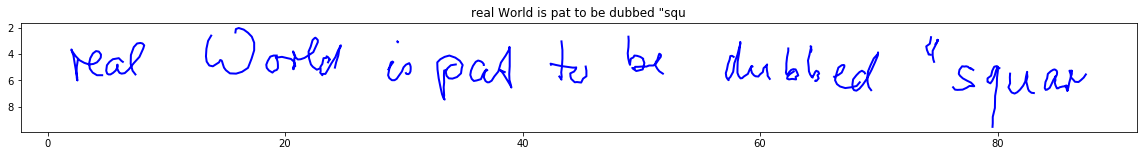

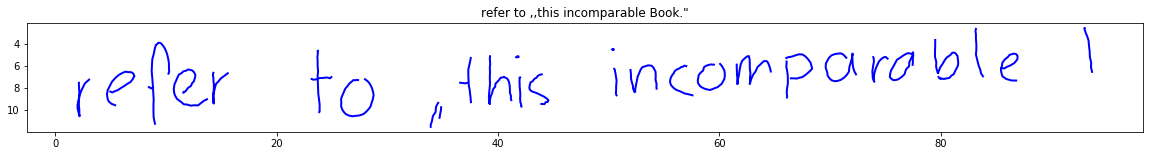

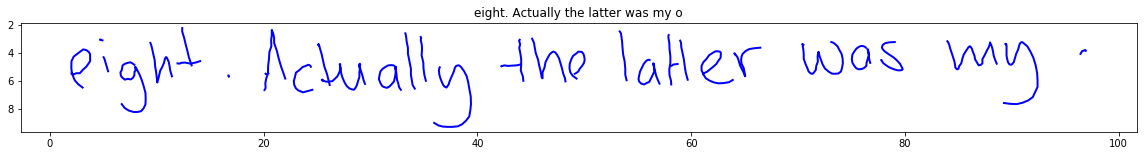

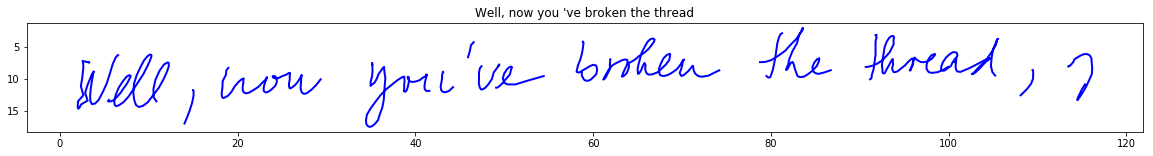

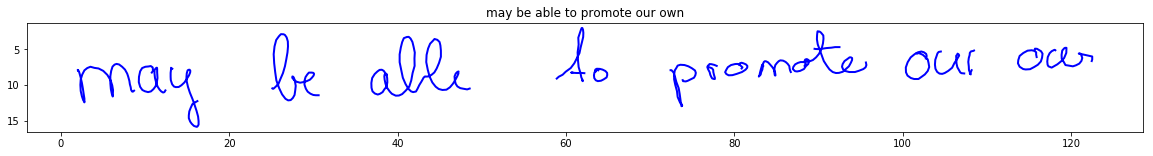

In [8]:
x, y, s, c = data_loader.next_batch()
print(data_loader.pointer)
for i in range(batch_size):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])